In [1]:
import pandas as pd  # Importing the pandas library to work with tabular data
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Loading data from CSV file into a DataFrame
df = pd.read_csv('./Datasets/8_LSTM_Data/time_series.csv', sep=';', decimal=',')

# Changing column names in the DataFrame
df.rename(columns={"X1 Average User Number ": "X1"}, inplace=True)
df.rename(columns={"X2 L.DLPwr.Avg": "X2"}, inplace=True)
df.rename(columns={"Y L.UL.Interference.Avg": "Y"}, inplace=True)
df.rename(columns={"X3 RA Success Rate": "X3"}, inplace=True)
df.rename(columns={"X4 RRC Setup Success Rate (Service)": "X4"}, inplace=True)
df.rename(columns={"X5 TA Mean": "X5"}, inplace=True)

# Selecting the first 12288 rows from the DataFrame
df = df[0:12288]

# Filling missing data in the DataFrame with values from previous rows
df = df.fillna(method='ffill')

# Converting the 'Start' column to datetime type and creating a new 'Date' column
df['Date'] = pd.to_datetime(df['Start'], format='%d.%m.%Y  %H:%M')

# Selecting only specified columns in the DataFrame
df = df[['Date', 'NE', 'X1', 'X2', 'X3', 'X4', 'X5', 'Y']]

# Selecting rows that have 'NE' value equal to '44_KOS0015A_111L18_O_SLOWIANSKA'
df = df[df['NE'] == '44_KOS0015A_111L18_O_SLOWIANSKA']

# Displaying information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 4032 to 4223
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    192 non-null    datetime64[ns]
 1   NE      192 non-null    object        
 2   X1      192 non-null    float64       
 3   X2      192 non-null    float64       
 4   X3      192 non-null    float64       
 5   X4      192 non-null    float64       
 6   X5      192 non-null    float64       
 7   Y       192 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.5+ KB


In [2]:
df.head()

,Date,NE,X1,X2,X3,X4,X5,Y
4032,2023-05-09 00:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,14.0744,42.5,95.4206,100.0000,0.9321,-117.0
4033,2023-05-09 01:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,13.3176,41.1,83.0103,99.8426,0.9625,-117.0
4034,2023-05-09 02:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,12.5942,40.5,77.2693,99.9491,1.0792,-117.0
4035,2023-05-09 03:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,22.1106,40.2,91.1665,99.9723,1.1067,-117.0
4036,2023-05-09 04:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,21.9133,41.2,93.0696,99.9304,1.0485,-117.0


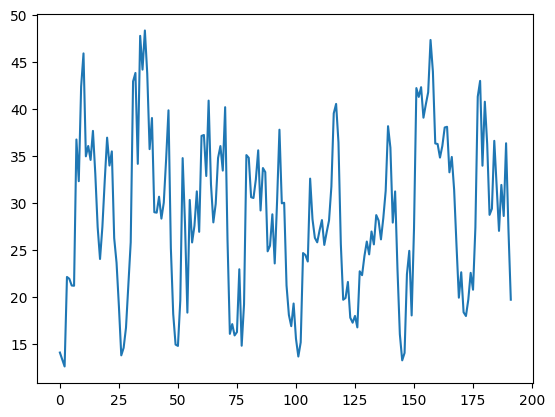

In [3]:
import matplotlib.pyplot as plt  # Importing the Matplotlib library for creating plots

timeseries = df[["X1"]].values.astype('float32')  # Selecting the "X1" column as a NumPy array with values of type float32

plt.plot(timeseries)  # Creating a line plot based on the time series data
plt.show()  # Displaying the plot

In [4]:
train_size = int(len(timeseries) * 0.67)  # Calculating the size of the training set as 67% of the total data length
test_size = len(timeseries) - train_size  # Calculating the size of the test set as the remaining portion of the data

train, test = timeseries[:train_size], timeseries[train_size:]  # Splitting the data into training and test sets

In [5]:
import torch  # Importing the PyTorch library

def create_dataset(dataset, lookback):
    X, y = [], []  # Initializing empty lists X (features) and y (labels)

    # Iterating through the input data to create samples
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]  # Creating a feature (history) of length "lookback"
        target = dataset[i+1:i+lookback+1]  # Creating a label (future values) of length "lookback"
        X.append(feature)  # Adding the feature to the list of features
        y.append(target)  # Adding the label to the list of labels

    return torch.tensor(X), torch.tensor(y)  # Converting lists to PyTorch tensors and returning them as the function result

In [6]:
lookback = 24  # Length of history (number of data points backward)

# Creating the training set
X_train, y_train = create_dataset(train, lookback=lookback)

# Creating the test set
X_test, y_test = create_dataset(test, lookback=lookback)

# Displaying the shape of the data sets
print(X_train.shape, y_train.shape)  # Displaying the shape of the training set
print(X_test.shape, y_test.shape)    # Displaying the shape of the test set

torch.Size([104, 24, 1]) torch.Size([104, 24, 1])
torch.Size([40, 24, 1]) torch.Size([40, 24, 1])


/tmp/ipykernel_235758/2996912896.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)  # Converting lists to PyTorch tensors and returning them as the function result


In [7]:
import torch.nn as nn  # Importowanie modułu nn z PyTorch

# Definicja klasy TSModel, która dziedziczy po nn.Module
class TSModel(nn.Module):
    def __init__(self):
        super().__init__()  # Inicjalizacja klasy bazowej nn.Module

        # Warstwa LSTM (Long Short-Term Memory) dla modelu sekwencyjnego
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)

        # Warstwa liniowa (fully connected) do przewidywania wyniku
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)  # Przepływ danych przez warstwę LSTM
        x = self.linear(x)   # Przepływ danych przez warstwę liniową
        return x  # Zwrócenie wyniku


In [8]:
import torch.optim as optim  # Importing the optim module from PyTorch
import torch.utils.data as data  # Importing the data module from PyTorch

# Initializing the model
model = TSModel()

# Initializing the optimizer (Adam) and the loss function (Mean Squared Error)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Creating a DataLoader to load training data in batches
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000  # Number of training epochs
for epoch in range(n_epochs):
    model.train()  # Setting the model to training mode
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)  # Making predictions
        loss = loss_fn(y_pred, y_batch)  # Calculating the loss
        optimizer.zero_grad()  # Resetting gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Updating model weights

    if epoch % 100 != 0:  # Displaying results every 100 epochs
        continue
    model.eval()  # Setting the model to evaluation mode (no training)
    with torch.no_grad():
        y_pred = model(X_train)  # Making predictions on training data
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))  # Calculating RMSE on training data
        y_pred = model(X_test)  # Making predictions on test data
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))  # Calculating RMSE on test data
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))  # Displaying results
torch.save(model.state_dict(), "./Models/Telecomunications_LSTM_model.pth")

Epoch 0: train RMSE 29.3190, test RMSE 32.1488
Epoch 100: train RMSE 5.7824, test RMSE 6.3312
Epoch 200: train RMSE 4.5675, test RMSE 5.5643
Epoch 300: train RMSE 4.0315, test RMSE 5.6103
Epoch 400: train RMSE 3.6966, test RMSE 5.8675
Epoch 500: train RMSE 3.4890, test RMSE 6.0651
Epoch 600: train RMSE 3.3269, test RMSE 6.0940
Epoch 700: train RMSE 3.0776, test RMSE 6.1707
Epoch 800: train RMSE 2.8884, test RMSE 6.3295
Epoch 900: train RMSE 2.6056, test RMSE 6.4460
Epoch 1000: train RMSE 2.4056, test RMSE 6.7120
Epoch 1100: train RMSE 2.2119, test RMSE 7.1329
Epoch 1200: train RMSE 2.1305, test RMSE 7.3609
Epoch 1300: train RMSE 2.0518, test RMSE 7.3533
Epoch 1400: train RMSE 2.0057, test RMSE 7.4453
Epoch 1500: train RMSE 1.9621, test RMSE 7.6909
Epoch 1600: train RMSE 1.9245, test RMSE 7.7562
Epoch 1700: train RMSE 1.9006, test RMSE 7.8407
Epoch 1800: train RMSE 1.8690, test RMSE 7.9395
Epoch 1900: train RMSE 1.8375, test RMSE 8.0937


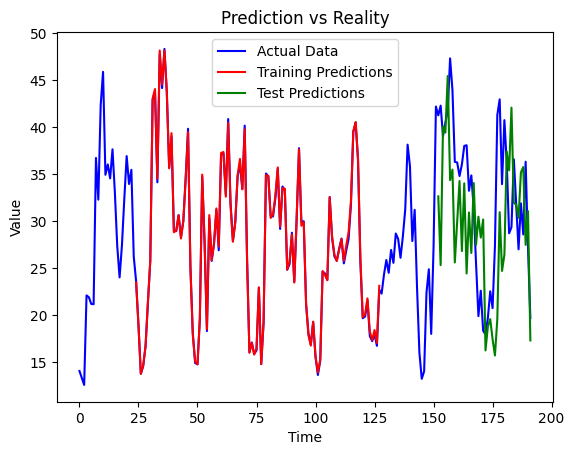

In [9]:
# Prediction vs Reality
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred_train = model(X_train)[:, -1, :]
    train_plot[lookback:train_size] = y_pred_train

    test_plot = np.ones_like(timeseries) * np.nan
    y_pred_test = model(X_test)[:, -1, :]
    test_plot[train_size + lookback:len(timeseries)] = y_pred_test

plt.plot(timeseries, c='b', label='Actual Data')
plt.plot(train_plot, c='r', label='Training Predictions')
plt.plot(test_plot, c='g', label='Test Predictions')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs Reality')
plt.legend()
plt.show()

In [10]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Pobieranie danych
stock_data = yf.download('AAPL', start='2020-01-01', end='2020-12-31')['Close']
stock_data = stock_data.values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(stock_data)
print(data_normalized)


[*********************100%%**********************]  1 of 1 completed
[[0.23567731]
 [0.22661991]
 [0.23397124]
 [0.22959774]
 [0.2444865 ]
 [0.26446232]
 [0.26663354]
 [0.28719871]
 [0.27392287]
 [0.26976642]
 [0.28186355]
 [0.29268902]
 [0.28598904]
 [0.28949413]
 [0.29423993]
 [0.2913862 ]
 [0.26235309]
 [0.28946308]
 [0.31009025]
 [0.30863239]
 [0.26409011]
 [0.26145353]
 [0.29306122]
 [0.301126  ]
 [0.31278883]
 [0.29672136]
 [0.30143611]
 [0.29541855]
 [0.31896154]
 [0.31173422]
 [0.31198242]
 [0.29352648]
 [0.30785693]
 [0.29755882]
 [0.27507053]
 [0.22894629]
 [0.19761776]
 [0.21179316]
 [0.15245508]
 [0.15195877]
 [0.23090046]
 [0.20146409]
 [0.24309064]
 [0.21263071]
 [0.20056454]
 [0.12965668]
 [0.18911876]
 [0.15837959]
 [0.07400974]
 [0.16625827]
 [0.05533674]
 [0.08837124]
 [0.06917089]
 [0.06330842]
 [0.01510596]
 [0.        ]
 [0.06982229]
 [0.0656038 ]
 [0.10567947]
 [0.07248987]
 [0.09441981]
 [0.09280684]
 [0.05130435]
 [0.06377368]
 [0.05285526]
 [0.11817986]
 [0.108

/home/tobi303/anaconda3/envs/PyEnv/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


1. Data Preparation for LSTM Model:
   - Transform the data into sequences to be used for training the model. Each sequence should contain closing prices from a specified number of consecutive days as input data and the closing price of the next day as output data.
   - Split the data into training and testing sets.

2. Building the LSTM Model:
   - Create a sequential model using LSTM layers.
   - Add an appropriate number of LSTM layers and neurons in each layer. You can experiment with different configurations.
   - Add a Dense layer at the end to predict the closing price.

3. Compiling and Training the Model:
   - Compile the model, choosing an optimizer (e.g., Adam) and a loss function (e.g., mean squared error).
   - Train the model on the training data, monitoring the results on the testing data.

4. Model Evaluation:
   - Evaluate the performance of the model on the testing data.
   - See how well the model predicts closing prices by comparing the predictions with the actual values.

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Download and prepare data
stock_data = yf.download('AAPL', start='2020-01-01', end='2020-12-31')['Close']
stock_data = stock_data.values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(stock_data)

# Prepare Data for LSTM Model
n_steps = 10  # Number of days to consider as input sequence

# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(data_normalized, n_steps)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])

In [12]:
# Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


I0000 00:00:1714415434.481370  245402 service.cc:145] XLA service 0x7f55800041a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714415434.481507  245402 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-04-29 20:30:34.526134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 20:30:34.774666: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


1/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.3733

I0000 00:00:1714415435.225086  245402 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.3713 - val_loss: 0.3428
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3145 - val_loss: 0.2875
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2373 - val_loss: 0.2257
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2075 - val_loss: 0.1517
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1213 - val_loss: 0.0684
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0437 - val_loss: 0.0242
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - val_loss: 0.0284
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - val_loss: 0.0152
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 13/50
7/7 ━━━━━

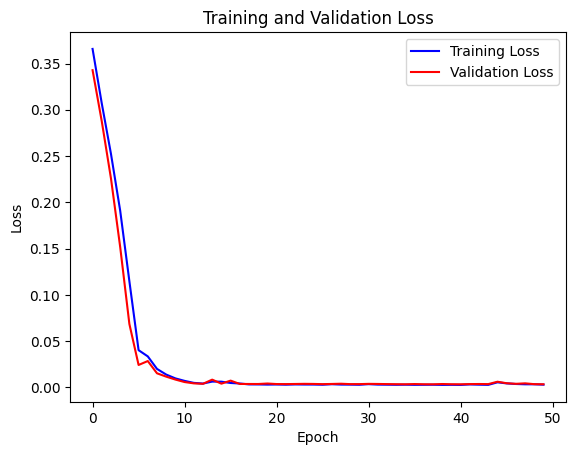

In [13]:
# Visualize Training and Validation Loss
plt.plot(history.history['loss'],c='b', label='Training Loss')
plt.plot(history.history['val_loss'],c='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


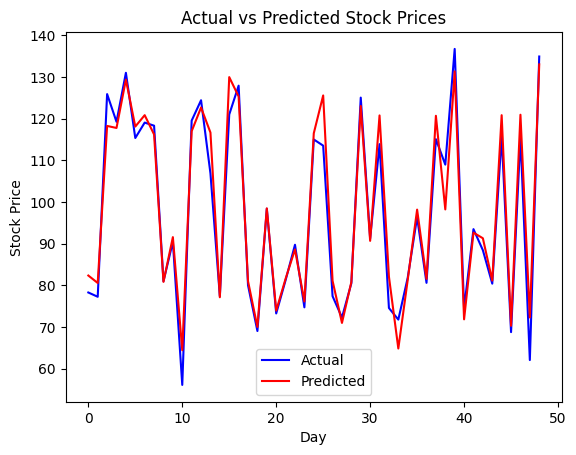

In [15]:
# Visualize Predictions vs Actual
plt.plot(y_test_original, c='b', label='Actual')
plt.plot(predictions, c='r', label='Predicted')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()